In [1]:
from datetime import timedelta
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4,plotTrajectoriesFile
from scipy import fftpack
import pandas as pd
from scipy.signal import butter,filtfilt
import scipy

### Generating Data

Either run the commented cells below to generate the 1D synthetic wave data, or use the files at the end of the section to import the data.

In [2]:
"""
U0=0.2
Uw=0.01
Ue=0.01
f=5e-5
k=1e-3
Le=10e3;

timestep = 300

# Periodic grids
Lx=8*2*np.pi/k
x=np.linspace(0,Lx,200,endpoint=False)
y=np.copy(x)
ym=np.mean(y);
# Time - 2 weeks
ts=np.array(range(0,(2*7*24*60**2),timestep))

T,Y,X=np.meshgrid(t,y,x,indexing='ij')

# estimate of the time taken to advect 1 grid cell
(x[2]-x[1])/U0
# estimate of "frequency" of eddy
U0/Le
"""

'\nU0=0.2\nUw=0.01\nUe=0.01\nf=5e-5\nk=1e-3\nLe=10e3;\n\ntimestep = 300\n\n# Periodic grids\nLx=8*2*np.pi/k\nx=np.linspace(0,Lx,200,endpoint=False)\ny=np.copy(x)\nym=np.mean(y);\n# Time - 2 weeks\nts=np.array(range(0,(2*7*24*60**2),timestep))\n\nT,Y,X=np.meshgrid(t,y,x,indexing=\'ij\')\n\n# estimate of the time taken to advect 1 grid cell\n(x[2]-x[1])/U0\n# estimate of "frequency" of eddy\nU0/Le\n'

In [3]:
"""
# Generate the flow, accounting for periodicity
xc=(U0*t % Lx)[:,None,None]
ut1=-2*Ue/Le*(X-xc)*np.exp(-((X-xc)**2+(Y-ym)**2)/Le**2)
vt1=2*Ue/Le*(Y-ym)*np.exp(-((X-xc)**2+(Y-ym)**2)/Le**2)
ut2=-2*Ue/Le*(X-(xc+x[-1]))*np.exp(-((X-(xc+x[-1]))**2+(Y-ym)**2)/Le**2)
vt2=2*Ue/Le*(Y-ym)*np.exp(-((X-(xc+x[-1]))**2+(Y-ym)**2)/Le**2)
ut3=-2*Ue/Le*(X+(-xc+x[-1]))*np.exp(-((X+(-xc+x[-1]))**2+(Y-ym)**2)/Le**2)
vt3=2*Ue/Le*(Y-ym)*np.exp(-((X+(-xc+x[-1]))**2+(Y-ym)**2)/Le**2)
ue=(ut1+ut2+ut3)
ve=(vt1+vt2+vt3)
# total flow
U=U0+Uw*np.sin(k*X)+ue
V=f*Uw/(k*U0)*np.cos(k*X)+ve
"""

'\n# Generate the flow, accounting for periodicity\nxc=(U0*t % Lx)[:,None,None]\nut1=-2*Ue/Le*(X-xc)*np.exp(-((X-xc)**2+(Y-ym)**2)/Le**2)\nvt1=2*Ue/Le*(Y-ym)*np.exp(-((X-xc)**2+(Y-ym)**2)/Le**2)\nut2=-2*Ue/Le*(X-(xc+x[-1]))*np.exp(-((X-(xc+x[-1]))**2+(Y-ym)**2)/Le**2)\nvt2=2*Ue/Le*(Y-ym)*np.exp(-((X-(xc+x[-1]))**2+(Y-ym)**2)/Le**2)\nut3=-2*Ue/Le*(X+(-xc+x[-1]))*np.exp(-((X+(-xc+x[-1]))**2+(Y-ym)**2)/Le**2)\nvt3=2*Ue/Le*(Y-ym)*np.exp(-((X+(-xc+x[-1]))**2+(Y-ym)**2)/Le**2)\nue=(ut1+ut2+ut3)\nve=(vt1+vt2+vt3)\n# total flow\nU=U0+Uw*np.sin(k*X)+ue\nV=f*Uw/(k*U0)*np.cos(k*X)+ve\n'

In [4]:
"""
ncfile_name="analytic_example_inputs.nc"
ncfile = Dataset(ncfile_name, 'w', format='NETCDF4')
ncfile.description = 'Synthetic data for Lagrangian Filtering test'

# dimensions
ncfile.createDimension('time', None)
ncfile.createDimension('x', np.size(x))
ncfile.createDimension('y', np.size(y))

# variables
time = ncfile.createVariable('time', 'f8', ('time',))
x1 = ncfile.createVariable('x', 'f8', ('x',))
y1 = ncfile.createVariable('y', 'f8', ('y',))
U1 = ncfile.createVariable('u', 'f8', ('time', 'y', 'x'))
V1 = ncfile.createVariable('v', 'f8', ('time', 'y', 'x'))
"""

'\nncfile_name="analytic_example_inputs.nc"\nncfile = Dataset(ncfile_name, \'w\', format=\'NETCDF4\')\nncfile.description = \'Synthetic data for Lagrangian Filtering test\'\n\n# dimensions\nncfile.createDimension(\'time\', None)\nncfile.createDimension(\'x\', np.size(x))\nncfile.createDimension(\'y\', np.size(y))\n\n# variables\ntime = ncfile.createVariable(\'time\', \'f8\', (\'time\',))\nx1 = ncfile.createVariable(\'x\', \'f8\', (\'x\',))\ny1 = ncfile.createVariable(\'y\', \'f8\', (\'y\',))\nU1 = ncfile.createVariable(\'u\', \'f8\', (\'time\', \'y\', \'x\'))\nV1 = ncfile.createVariable(\'v\', \'f8\', (\'time\', \'y\', \'x\'))\n'

In [5]:
"""
U1[:] = U
V1[:] = V
time[:] = ts
x1[:] = x
y1[:] = y
    
ncfile.close()
"""

'\nU1[:] = U\nV1[:] = V\ntime[:] = ts\nx1[:] = x\ny1[:] = y\n    \nncfile.close()\n'

In [6]:
"""
filenames = {
    "U": ncfile_name, 
    "V": ncfile_name
}
variables = {"U": "u", "V": "v"}
dimensions = {"lon": "x", "lat": "y", "time": "time"}

fieldset = FieldSet.from_netcdf(filenames, variables, dimensions,mesh="flat")#,interp_method ='cubic')
"""

'\nfilenames = {\n    "U": ncfile_name, \n    "V": ncfile_name\n}\nvariables = {"U": "u", "V": "v"}\ndimensions = {"lon": "x", "lat": "y", "time": "time"}\n\nfieldset = FieldSet.from_netcdf(filenames, variables, dimensions,mesh="flat")#,interp_method =\'cubic\')\n'

In [7]:
"""
# Periodicity stuff left/right

fieldset.add_constant('halo_west', fieldset.U.grid.lon[0])
fieldset.add_constant('halo_east', fieldset.U.grid.lon[-1])
fieldset.add_constant('halo_north', fieldset.U.grid.lat[0])
fieldset.add_constant('halo_south', fieldset.U.grid.lat[-1])



fieldset.add_periodic_halo(zonal=True,meridional = True)

def periodicBC(particle, fieldset, time):
    
    if particle.lon < fieldset.halo_west:
        particle.lon += fieldset.halo_east - fieldset.halo_west
    elif particle.lon > fieldset.halo_east:
        particle.lon -= fieldset.halo_east - fieldset.halo_west

        
    if particle.lat < fieldset.halo_north:
        particle.lat += fieldset.halo_south - fieldset.halo_north
    elif particle.lat > fieldset.halo_south:
        particle.lat -= fieldset.halo_south - fieldset.halo_north
"""

"\n# Periodicity stuff left/right\n\nfieldset.add_constant('halo_west', fieldset.U.grid.lon[0])\nfieldset.add_constant('halo_east', fieldset.U.grid.lon[-1])\nfieldset.add_constant('halo_north', fieldset.U.grid.lat[0])\nfieldset.add_constant('halo_south', fieldset.U.grid.lat[-1])\n\n\n\nfieldset.add_periodic_halo(zonal=True,meridional = True)\n\ndef periodicBC(particle, fieldset, time):\n    \n    if particle.lon < fieldset.halo_west:\n        particle.lon += fieldset.halo_east - fieldset.halo_west\n    elif particle.lon > fieldset.halo_east:\n        particle.lon -= fieldset.halo_east - fieldset.halo_west\n\n        \n    if particle.lat < fieldset.halo_north:\n        particle.lat += fieldset.halo_south - fieldset.halo_north\n    elif particle.lat > fieldset.halo_south:\n        particle.lat -= fieldset.halo_south - fieldset.halo_north\n"

In [8]:
"""
xs = np.linspace(0,Lx,10,endpoint=False)
ys = np.copy(xs)

x_index = 4
y_index = 4

lons,lats=np.meshgrid(xs,ys,indexing='ij')

pset = ParticleSet.from_list(fieldset=fieldset,   # the fields on which the particles are advected
                             pclass=JITParticle,  # the type of particles (JITParticle or ScipyParticle)
                             lon=[x[x_index]], # a vector of release longitudes 
                             lat=[y[y_index]]) # a vector of release latitudes
"""

"\nxs = np.linspace(0,Lx,10,endpoint=False)\nys = np.copy(xs)\n\nx_index = 4\ny_index = 4\n\nlons,lats=np.meshgrid(xs,ys,indexing='ij')\n\npset = ParticleSet.from_list(fieldset=fieldset,   # the fields on which the particles are advected\n                             pclass=JITParticle,  # the type of particles (JITParticle or ScipyParticle)\n                             lon=[x[x_index]], # a vector of release longitudes \n                             lat=[y[y_index]]) # a vector of release latitudes\n"

In [9]:
"""
output_file = pset.ParticleFile(name="TEST4.nc", outputdt=timestep) # the file name and the time step of the outputs

pset.execute(AdvectionRK4 + pset.Kernel(periodicBC),                 # the kernel (which defines how particles move)
             runtime=1206000,              # the total length of the run
             dt=300,                       # the timestep of the kernel
             output_file=output_file)
"""

'\noutput_file = pset.ParticleFile(name="TEST4.nc", outputdt=timestep) # the file name and the time step of the outputs\n\npset.execute(AdvectionRK4 + pset.Kernel(periodicBC),                 # the kernel (which defines how particles move)\n             runtime=1206000,              # the total length of the run\n             dt=300,                       # the timestep of the kernel\n             output_file=output_file)\n'

Load in the data with the cell below:

In [10]:
U = np.load("U_array.npy")
V = np.load("V_array.npy")

Some important variables that should also be loaded in:

In [11]:
vs = U[:,100,100]
h = 300
ts=np.array(range(0,(2*7*24*60**2),h))
k=1e-3
Lx=8*2*np.pi/k
f=5e-5
x=np.linspace(0,Lx,200,endpoint=False)
y=np.copy(x)
timestep = h
Ntime = np.shape(U)[0]
t_mid = int(Ntime/2)
U0 = .2

### Eularian Mean Definition

In order to calculate the Eularian Mean, we fix a point in space and then take the average velocity of a particle at that point over each timestep. In other words, we record the velocity at that exact point in space at each timestep; this creates a timeseries for which we can calculate the average. We can repeat this at different points in space in order to get a full picture of the domain. In the following code, we will create a grid on our domain and calculate the Eularian mean at each point on the grid.

In the cell below we calculate the Eularian mean of the U_velocity on our domain:

C:\Users\alexa\AppData\Local\Temp\ipykernel_3640\3153240827.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  t_mid = np.int(Ntime/2.)


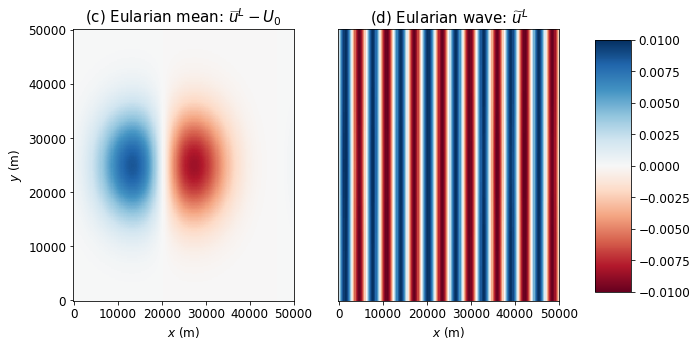

In [12]:
freqss = scipy.fftpack.fftfreq(ts.size, ts[1]-ts[0])
imax = np.shape(U)[1]
jmax = np.shape(U)[2]
U_wave = np.empty_like(U)

U_mean = np.mean(U, axis=0) 
t_mid = np.int(Ntime/2.)

fig1=plt.figure(figsize=(10,5)) 

plt.subplot(1,2,1)
plt.pcolor(x,y, U[t_mid,:,:]-U_mean,vmin=-0.01,vmax=0.01,cmap='RdBu')
plt.title(r'(c) Eularian mean: $\widebar{u}^L-U_0$',fontsize=15)
plt.tick_params(labelsize=12)
plt.ylabel(r'$y$ (m)',fontsize=12)
plt.xlabel(r'$x$ (m)',fontsize=12)

plt.subplot(1,2,2)
im=plt.pcolor(x,y,U_mean-U0,vmin=-0.01,vmax=0.01,cmap='RdBu')
plt.title('u wave'); 
plt.title(r'(d) Eularian wave: $\widetilde{u}^L$',fontsize=15);
plt.yticks([])
plt.tick_params(labelsize=12)
plt.xlabel(r'$x$ (m)',fontsize=12) 

plt.subplots_adjust(right=0.8)
cbar_ax = fig1.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(im, cax=cbar_ax)
plt.tick_params(labelsize=12)


### Lagrangian Mean Definition

In Lagrangian Averaging, we track a particle as it moves through space and measure its velocity (or any other property) at each time step. In other words we create a timeseries for the velocity of an individual particle; each element in the timeseries is the observed velocity of the particle, but each element may be at a different point in space. We then take an average of that timeseries. We can repeat this for particles that start at different points in space. At time 0, we seed a particle at each gridpoint and so we end up with 1 timeseries for each individual particle. 

First we have the results from Shakespear et al using their Ocean Parcels package:

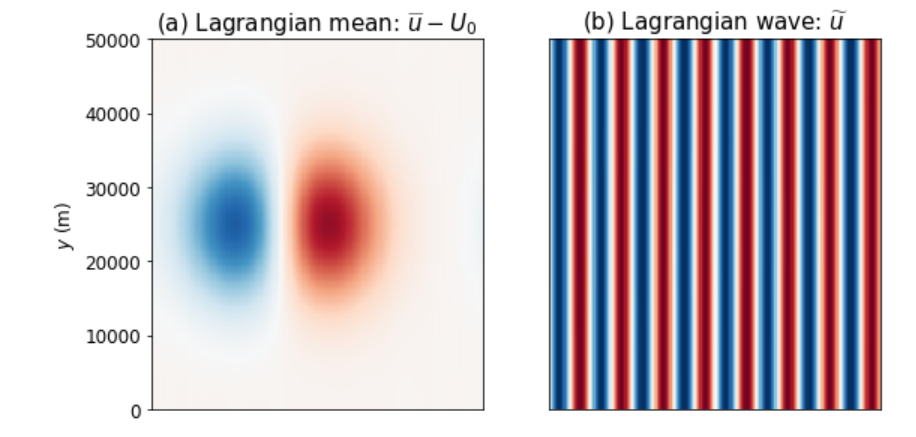


Next we have my version of the Lagrangian particle tracking. You can either run the commented out code below for the particle tracking, or load in the data from the files at the end of this section.

In [13]:
"""
halo_west = x[0]
halo_east = x[-1]
halo_south = y[0]
halo_north = y[-1]

def leftright(x_cord):
    
    if x_cord < halo_west:
        x_cord += halo_east - halo_west
    elif x_cord > halo_east:
        x_cord -= halo_east - halo_west
        
    return x_cord

def updown(y_cord):
    
    if y_cord < halo_south:
        y_cord += halo_north - halo_south
    elif y_cord > halo_north:
        y_cord -= halo_north - halo_south
    
    return y_cord

vec_leftright = np.vectorize(leftright)
vec_updown = np.vectorize(updown)

imax = np.shape(U)[1]
jmax = np.shape(U)[2]
dt = timestep
dx = x[1]-x[0]
dy = y[1]-y[0]
x_pad = np.concatenate(([-dx],x,[x[-1]+dx]),axis=0)
y_pad = np.concatenate(([-dy],y,[y[-1]+dy]),axis=0)
U_pad = np.zeros((imax+2,jmax+2))
V_pad = np.zeros((imax+2,jmax+2))

Ntime = np.shape(U)[0]
t_mid = np.int(Ntime/2.)
"""

'\nhalo_west = x[0]\nhalo_east = x[-1]\nhalo_south = y[0]\nhalo_north = y[-1]\n\ndef leftright(x_cord):\n    \n    if x_cord < halo_west:\n        x_cord += halo_east - halo_west\n    elif x_cord > halo_east:\n        x_cord -= halo_east - halo_west\n        \n    return x_cord\n\ndef updown(y_cord):\n    \n    if y_cord < halo_south:\n        y_cord += halo_north - halo_south\n    elif y_cord > halo_north:\n        y_cord -= halo_north - halo_south\n    \n    return y_cord\n\nvec_leftright = np.vectorize(leftright)\nvec_updown = np.vectorize(updown)\n\nimax = np.shape(U)[1]\njmax = np.shape(U)[2]\ndt = timestep\ndx = x[1]-x[0]\ndy = y[1]-y[0]\nx_pad = np.concatenate(([-dx],x,[x[-1]+dx]),axis=0)\ny_pad = np.concatenate(([-dy],y,[y[-1]+dy]),axis=0)\nU_pad = np.zeros((imax+2,jmax+2))\nV_pad = np.zeros((imax+2,jmax+2))\n\nNtime = np.shape(U)[0]\nt_mid = np.int(Ntime/2.)\n'

In [14]:
"""
import time
start = time.time()


U_pad = np.zeros((imax+2,jmax+2))
V_pad = np.zeros((imax+2,jmax+2))

yy,xx = np.meshgrid(x,y,indexing='ij')

U_prtcl = np.zeros((Ntime, np.shape(xx)[0], np.shape(yy)[1]))
V_prtcl = np.zeros((Ntime, np.shape(xx)[0], np.shape(yy)[1])) 

xcords = xx
ycords = yy

for ts in range(t_mid,Ntime):
    
    U_pad[1:-1,1:-1] = U[ts,:,:]
    U_pad[0,:] = U_pad[-2,:]
    U_pad[-1,:] = U_pad[1,:]
    U_pad[:,0] = U_pad[:,-2]
    U_pad[:,-1] = U_pad[:,1]
    V_pad[1:-1,1:-1] = V[ts,:,:]
    V_pad[0,:] = V_pad[-2,:]
    V_pad[-1,:] = V_pad[1,:]
    V_pad[:,0] = V_pad[:,-2]
    V_pad[:,-1] = V_pad[:,1]
    
    U_pad[1:-1,1:-1] = U[ts,:,:]
    U_pad[0,:] = U_pad[-2,:]
    U_pad[-1,:] = U_pad[1,:]
    U_pad[:,0] = U_pad[:,-2]
    U_pad[:,-1] = U_pad[:,1]
    V_pad[1:-1,1:-1] = V[ts,:,:]
    V_pad[0,:] = V_pad[-2,:]
    V_pad[-1,:] = V_pad[1,:]
    V_pad[:,0] = V_pad[:,-2]
    V_pad[:,-1] = V_pad[:,1]
    
    
    x_vel_ts = np.vectorize(scipy.interpolate.interp2d(x=x_pad,y=y_pad, z=U_pad,kind = 'cubic'))
    y_vel_ts = np.vectorize(scipy.interpolate.interp2d(x=x_pad,y=y_pad, z=V_pad,kind = 'cubic'))
    
    
    U_velocity = x_vel_ts(xcords,ycords)
    V_velocity = y_vel_ts(xcords,ycords)
    
    xcords += dt*U_velocity
    ycords += dt*V_velocity
    
    xcords = vec_leftright(xcords)
    ycords = vec_updown(ycords)

    U_prtcl[ts,:,:] = U_velocity
    V_prtcl[ts,:,:] = V_velocity
    
xcords = xx
ycords = yy
    
    
for ts in range(t_mid,-1,-1):
    
    U_pad[1:-1,1:-1] = U[ts,:,:]
    U_pad[0,:] = U_pad[-2,:]
    U_pad[-1,:] = U_pad[1,:]
    U_pad[:,0] = U_pad[:,-2]
    U_pad[:,-1] = U_pad[:,1]
    V_pad[1:-1,1:-1] = V[ts,:,:]
    V_pad[0,:] = V_pad[-2,:]
    V_pad[-1,:] = V_pad[1,:]
    V_pad[:,0] = V_pad[:,-2]
    V_pad[:,-1] = V_pad[:,1]
    
    
    x_vel_ts = np.vectorize(scipy.interpolate.interp2d(x=x_pad,y=y_pad, z=U_pad,kind = 'cubic'))
    y_vel_ts = np.vectorize(scipy.interpolate.interp2d(x=x_pad,y=y_pad, z=V_pad,kind = 'cubic'))
    
    
    U_velocity = x_vel_ts(xcords,ycords)
    V_velocity = y_vel_ts(xcords,ycords)
    
    xcords = xcords - dt*U_velocity
    ycords = xcords - dt*V_velocity
    
    xcords = vec_leftright(xcords)
    ycords = vec_updown(ycords)

    U_prtcl[ts,:,:] = U_velocity
    V_prtcl[ts,:,:] = V_velocity
    
end = time.time()
print(end - start)
"""

"\nimport time\nstart = time.time()\n\n\nU_pad = np.zeros((imax+2,jmax+2))\nV_pad = np.zeros((imax+2,jmax+2))\n\nyy,xx = np.meshgrid(x,y,indexing='ij')\n\nU_prtcl = np.zeros((Ntime, np.shape(xx)[0], np.shape(yy)[1]))\nV_prtcl = np.zeros((Ntime, np.shape(xx)[0], np.shape(yy)[1])) \n\nxcords = xx\nycords = yy\n\nfor ts in range(t_mid,Ntime):\n    \n    U_pad[1:-1,1:-1] = U[ts,:,:]\n    U_pad[0,:] = U_pad[-2,:]\n    U_pad[-1,:] = U_pad[1,:]\n    U_pad[:,0] = U_pad[:,-2]\n    U_pad[:,-1] = U_pad[:,1]\n    V_pad[1:-1,1:-1] = V[ts,:,:]\n    V_pad[0,:] = V_pad[-2,:]\n    V_pad[-1,:] = V_pad[1,:]\n    V_pad[:,0] = V_pad[:,-2]\n    V_pad[:,-1] = V_pad[:,1]\n    \n    U_pad[1:-1,1:-1] = U[ts,:,:]\n    U_pad[0,:] = U_pad[-2,:]\n    U_pad[-1,:] = U_pad[1,:]\n    U_pad[:,0] = U_pad[:,-2]\n    U_pad[:,-1] = U_pad[:,1]\n    V_pad[1:-1,1:-1] = V[ts,:,:]\n    V_pad[0,:] = V_pad[-2,:]\n    V_pad[-1,:] = V_pad[1,:]\n    V_pad[:,0] = V_pad[:,-2]\n    V_pad[:,-1] = V_pad[:,1]\n    \n    \n    x_vel_ts = np

Load in the data with the cell below:

In [15]:
U_prtcl = np.load("U_prtcl.npy")
V_prtcl = np.load("V_prtcl.npy")

In the cell below we calculate the Lagrangian mean of the U_velocity on our domain:

C:\Users\alexa\AppData\Local\Temp\ipykernel_3640\2079085253.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  t_mid = np.int(Ntime/2.)


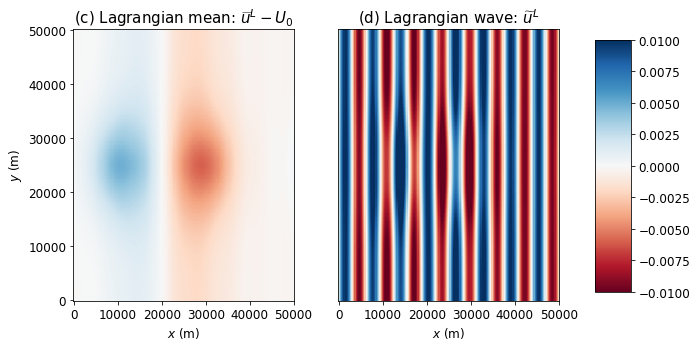

In [16]:
U_mean = np.mean(U_prtcl, axis=0) 
t_mid = np.int(Ntime/2.)

fig1=plt.figure(figsize=(10,5))        
plt.subplot(1,2,1)
plt.pcolor(x,y,U_mean-U0,vmin=-0.01,vmax=0.01,cmap='RdBu')
plt.title(r'(c) Lagrangian mean: $\widebar{u}^L-U_0$',fontsize=15)
plt.tick_params(labelsize=12)
plt.ylabel(r'$y$ (m)',fontsize=12)
plt.xlabel(r'$x$ (m)',fontsize=12)


plt.subplot(1,2,2)
im=plt.pcolor(x,y, U[t_mid,:,:]-U_mean,vmin=-0.01,vmax=0.01,cmap='RdBu')
plt.title('u wave'); 
plt.title(r'(d) Lagrangian wave: $\widetilde{u}^L$',fontsize=15);
plt.yticks([])
plt.tick_params(labelsize=12)
plt.xlabel(r'$x$ (m)',fontsize=12) 

plt.subplots_adjust(right=0.8)
cbar_ax = fig1.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(im, cax=cbar_ax)
plt.tick_params(labelsize=12)


### Alternatives to Simple Averaging

For both the Lagrangian and Eularian averaging, once we have obtained our timeseries (either for a point in space, or a specific particle), we calculate a simple mean. However, instead of finding the mean of the data, we have other options from the field of signal processing:

1) Low pass filter - this is usually used to smooth data and get rid of noise in time series. Therefore it is a form of averaging and can be used to give us the Lagrangian Mean.

2) High pass filter - this is usually used for edge detection and image sharpening. It is the opposite of the Low pass filter and can be calculated by doing: wave - LP filter. This gives us the Lagrangian wave.

3) Band pass filter - this is kind of a mix between the low pass and high pass filters.


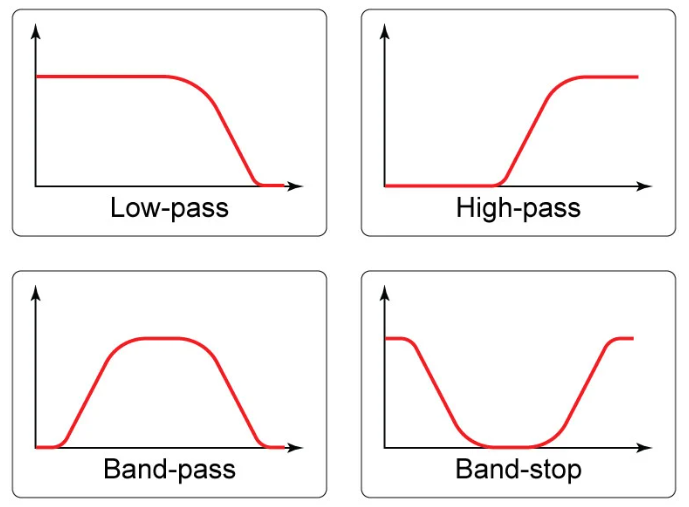

4) Gaussian smoothing kernel - like a low pass filter, this is used to smooth data and blur images. Therefore it is a form of averaging and can be used to give us the Lagrangian Mean.

### Equivalent techniques to Signal Processing from Trefethen

#### Note that the following is very rough

For functions over $2\pi$ periodic grids, we found that doing a Low pass filter, via a frequency cut off, is equivalent to the band limited interpolant from equation 2.10 from Trefethen:

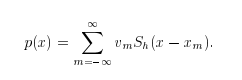

where $S_h$ is the non-periodic sinc function defined in equation 2.8 as:

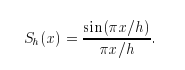

In the semi-discrete setting, this function is derived from the fact that any general grid function, $v$, can be written as 

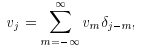

where $\delta$ is the Kropnecker Delta function. The Fourier Transform of the Kronecker Delta function, $\delta$, is the constant $\hat{\delta}(k) = h$ for all $k \in [-\frac{\pi}{h},\frac{\pi}{h}]$. Therefore, its band limited interpolant is the sinc function defined as above. The calculation for this is as follows:

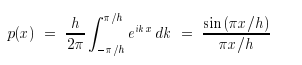

Hence, from the linearity of the semi-discrete Fourier Transform, it follows that the band limited interpolant of some grid function $v$, is a linear combination of translated sinc functions.

A frequency cut off is essentially a narrowing of the k values in the frequency domain (as we would be setting frequencies of k values with magnitude greater than the cut off to 0). Thus we are changing our range of values in the frequency domain from $k \in [-\frac{\pi}{h},\frac{\pi}{h}]$ to $k \in [-\frac{\pi}{h'},\frac{\pi}{h'}]$, where $h'$ is our frequency cut off. Thus the above derivation becomes

$$
p(x) = \frac{h}{2\pi} \int^{\frac{\pi}{h'}}_{-\frac{\pi}{h'}} e^{ikx} dk = \frac{\sin(\pi x / h')}{\pi x /h}.
$$

Instead of using the non-periodic sinc function in the semi-discrete setting, we can instead choose to use the periodic sinc function, defined in equation 3.7 of Trefethen as:

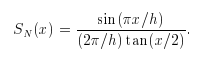

So our band limited interpolant would become:

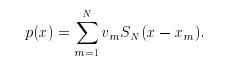

Applying the same logic regarding frequency cut offs as before, we end up with 

$$
S_N(x) = \frac{\sin(\pi x / h')}{(2\pi / h)\tan(x/2)}.
$$

Thus the Low pass and high pass filters used for averaging are equivalent to the periodic and non-peridoic sinc interpolants defined above.

Similarly, the band pass filter is equivalent to the following expression 

$$
v_j = \sum^{N}_{1} v_m S_{N'}(x - x_m)
$$

where $S_{N'}$ is defined as:

$$
S_{N'} = \frac{\sin(\pi x / h) - \sin(\pi x / h')}{\pi x /h}
$$

### Going from periods of $2 \pi$ to L

We must note that the sinc interpolants defined above are actually defined for functions on periodic domains of length $2 \pi$. We must transform these so that they work for functions on periodic grids of length L. This works similarly for all 3 interpolants, so I will just explain it for the non-periodic sinc interpolant:

$$
f(x) =  \frac{\sin(\pi x / h')}{\pi x /h}.
$$

Define $F$ as $F(x) = f(\frac{2\pi}{L} x)$. So

$$
F(x) = \frac{\sin(\frac{2 \pi^2 x}{h' L})}{(\frac{2 \pi}{h})\tan(\frac{\pi x}{L})}
$$

The above calculation is essentially a way of scaling the function. Instead of the scaling the function itself, we can instead scale its inputs. In other words, we can scale the grid function $v$ and its temporal inputs, $t$, by $\frac{2 \pi}{L}$.

### Testing Signal Processing and Trefethen Averaging Techniques 

We will test all the interpolants and filters mentioned above on individual timeseries. We will do this both with a simple function and with an individual timeseries taken from our synthetic wave data.

First we will define a function and add noise to it:

In [17]:
N = 500                                        
N_half = int(N/2)                              
func_L = 10
xs = np.linspace(0,10,N,endpoint = False) 
func_h = xs[1]-xs[0]    

def v(x):                     
    return np.exp(np.sin(np.pi*x/5)) -1 

noise = np.random.normal(0, .1, xs.shape)  

func_vs = v(xs) + noise        

Next we will obtain a timeseries from our synthetic wave data:

In [18]:
vs = U[:,100,100]
h = 300
ts=np.array(range(0,(2*7*24*60**2),h))
k=1e-3
Lx=8*2*np.pi/k
f=5e-5
x=np.linspace(0,Lx,200,endpoint=False)
y=np.copy(x)
timestep = h
Ntime = np.shape(U)[0]
t_mid = int(Ntime/2)


##### Low Pass Filter

C:\Users\alexa\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


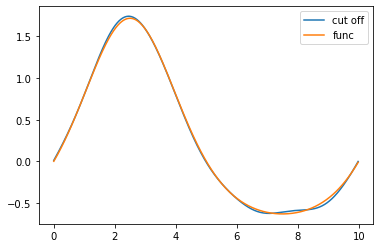

In [19]:
## Low Pass Filter - noisy function

func_freqss = fftpack.fftfreq(xs.size,func_h)
vf = fftpack.fft(func_vs)
freq = 0.5
vf[abs(func_freqss) >freq] = 0  
res = fftpack.ifft(vf)
plt.plot(xs,res,label="cut off")
plt.plot(xs,v(xs),label="func")
plt.legend()

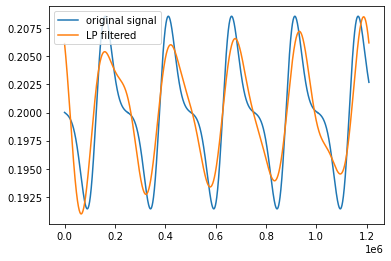

In [20]:
## Low Pass Filter - synthetic data

freqss = fftpack.fftfreq(ts.size,h)
vf = fftpack.fft(vs)
freq = f/(2*np.pi)
vf[abs(freqss) <(freq)] = 0  
res = np.real(fftpack.ifft(vf))
plt.plot(ts,vs,label = 'original signal')
plt.plot(ts,vs-res,label = 'LP filtered')
plt.legend()


Note that in the above sell we calculate the LP filter by doing signal - HP. We chose the cut off frequency to be $\frac{f}{2\pi}$ because this is what Shakespeare used.

##### Side Note - Finding a correspondance between cut off frequency in LP/HP filter and h' in sinc interpolants

As mentioned previously, the sinc interpolants are euqivalent to cut off frequency filters. In order to find the approximate correspondance between $h'$ in the interpolants, and the cut off frequencies in the filters, we will find a ratio between the cut off frequency and the maximum frequency in the data. So with the synthetic data we get:

In [21]:
ratio = np.max(abs(freqss))/freq
print(ratio)

209.43951023931956


Therefore, we need to define $h'$ as $h' = 209 h$. Similarly for the clean function we get:

In [22]:
ratio = ratio = np.max(abs(func_freqss))/.5
print(ratio)

50.0


Thus for the function data, $h' = 50h$.

##### Non-Periodic & Periodic Sinc Interpolants 

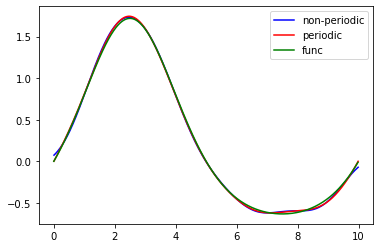

In [23]:
## Sinc interpolation - synthetic data, scaling function

h =  xs[1]-xs[0]
L = xs[-1]-xs[0]
h_new = h*(2*np.pi/L)
xx1 = xs + h_new/2
p = np.zeros_like(xx1)
p2 = np.zeros_like(xx1)

for i, vi in enumerate(func_vs):
    hprime = 50*h_new
    p += vi*np.sin(2*np.pi*np.pi*(xx1-xs[i])/hprime/L)/(2*np.pi*np.pi*(xx1-xs[i])/h_new/L)          
    p2 += vi*np.sin(2*np.pi*np.pi*(xx1-xs[i])/hprime/L)/(2*np.pi*np.tan(np.pi*(xx1-xs[i])/L)/h_new) 
    
val = 100
plt.plot(xx1,p,'b',label="non-periodic")
plt.plot(xx1,p2,'r',label="periodic")
plt.plot(xs,v(xs),'g',label = "func")

plt.legend()

0.012566370614359173


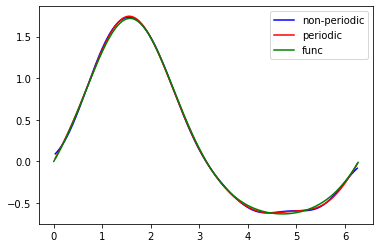

In [24]:
## Sinc interpolation - synthetic data, scaling data

vs1 = v(xs)
xx1 = xs[2:-2] + h/2
p = np.zeros_like(xx1)
p2 = np.zeros_like(xx1)
L = 10
xx1 = xx1/L*(2*np.pi)
xs = xs/L*(2*np.pi)
h =  xs[1]-xs[0]
print(h)


for i, vi in enumerate(func_vs):
    hprime = 50*h
    p += vi*np.sin(np.pi*(xx1-xs[i])/hprime)/(np.pi*(xx1-xs[i])/h)
    p2 += 1/(2*np.pi/h)*vi*np.sin(np.pi*(xx1-xs[i])/hprime)/np.tan((xx1-xs[i])/2)    
    
fig, ax = plt.subplots(1,1, figsize = (6,4))
ax.plot(xx1,p,'b',label="non-periodic")
plt.plot(xx1,p2,'r',label="periodic")

ax.plot(xs,vs1,'g',label = "func")

ax.legend()


### Resetting data

xs = np.linspace(0,10,N,endpoint = False) # x values in 1D periodic grid
h = xs[1]-xs[0]
xx1 = xs + h/2

##### High Pass Filter

C:\Users\alexa\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


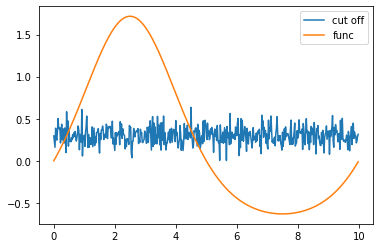

In [25]:
## High Pass Filter - noisy function

func_freqss = fftpack.fftfreq(xs.size,func_h)
vf = fftpack.fft(func_vs)
freq = 0.5
vf[abs(func_freqss) > freq] = 0  
res = fftpack.ifft(vf)
plt.plot(xs,func_vs - res+0.3,label="cut off")
plt.plot(xs,v(xs),label="func")
plt.legend()

The high pass filter has just left us with lots of noise - the wave's frequency was set to 0.

##### Non-Periodic & Periodic Sinc Interpolants 


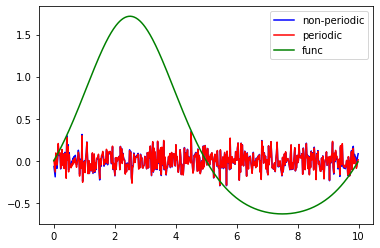

In [26]:
## Sinc interpolation - synthetic data, scaling function

h =  xs[1]-xs[0]
L = xs[-1]-xs[0]
h_new = h*(2*np.pi/L)
xx1 = xs + h_new/2
p = np.zeros_like(xx1)
p2 = np.zeros_like(xx1)

for i, vi in enumerate(func_vs):
    hprime = 50*h_new
    p += vi*np.sin(2*np.pi*np.pi*(xx1-xs[i])/hprime/L)/(2*np.pi*np.pi*(xx1-xs[i])/h_new/L)          
    p2 += vi*np.sin(2*np.pi*np.pi*(xx1-xs[i])/hprime/L)/(2*np.pi*np.tan(np.pi*(xx1-xs[i])/L)/h_new) 
    
val = 100
plt.plot(xx1,func_vs-p,'b',label="non-periodic")
plt.plot(xx1,func_vs-p2,'r',label="periodic")
plt.plot(xs,v(xs),'g',label = "func")

plt.legend()

While high pass filter doesnt look very useful here, it will be. Sometimes the high pass filters are not just unwanted noise (they are waves that we can get some information from). That being said in the geophysical application we usually care more about low pass part. This is the meaning of the decomposition: decomposing the flow to a slow (LP) and fast part (HP).

##### Band Pass Sinc Interpolants 


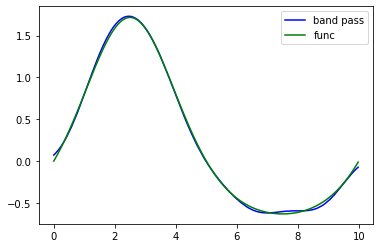

In [27]:
## Band Pass Filter - function data - scaling function


h = xs[1]-xs[0]
L = xs[-1]-xs[0]
h_new = h*(2*np.pi/L)
xx1 = xs + h_new/200
pp = np.zeros_like(xx1)
for i, vi in enumerate(func_vs):
    hprime = 50*h_new
    pp += vi*(np.sin(2*np.pi*np.pi*(xx1-xs[i])/h_new/L)-np.sin(2*np.pi*np.pi*(xx1-xs[i])/hprime/L))/(2*np.pi*np.pi*(xx1-xs[i])/h_new/L)            
    
plt.plot(xx1,func_vs - pp,'b',label="band pass")
plt.plot(xx1,v(xx1),'g',label = "func")
plt.legend()

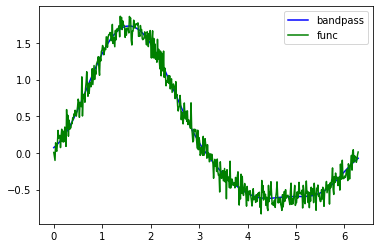

In [28]:
## Bandpass filter - function data - scaling axis
L = xs[-1]-xs[0]
xx1 = xs + h/200
pp = np.zeros_like(xx1)
xx1 = xx1/L*(2*np.pi)
xs = xs/L*(2*np.pi)
h = xs[1]-xs[0]


for i, vi in enumerate(func_vs):
    hprime = 50*h
    pp += vi*(np.sin(np.pi*(xx1-xs[i])/h)-np.sin(np.pi*(xx1-xs[i])/hprime))/(np.pi*(xx1-xs[i])/h)            
    
fig, ax = plt.subplots(1,1, figsize = (6,4))
ax.plot(xx1,func_vs - pp,'b',label="bandpass")
ax.plot(xs,func_vs,'g',label = "func")

ax.legend()

### Resetting data

xs = np.linspace(0,10,N,endpoint = False) # x values in 1D periodic grid
h = xs[1]-xs[0]
xx1 = xs + h/200

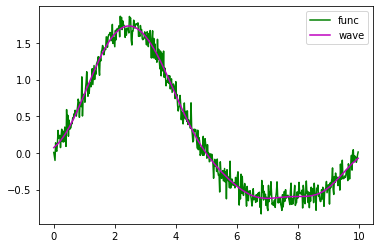

In [29]:
## Bandpass filter - function data - scaling axis (coded slightly differently)

xx1 = xs + h/200
L = xs[-1]-xs[0]
xs_new = xs/L*2*np.pi
h = xs_new[1]-xs_new[0]
xx1_new = xs_new + h/1000
p_wave = np.zeros_like(xx1_new)
for i, vi in enumerate(func_vs):
    hprime = 50*h
    p_wave += vi*(np.sin(np.pi*(xx1_new-xs_new[i])/h)-np.sin(np.pi*(xx1_new-xs_new[i])/(hprime)))/(np.pi*(xx1_new-xs_new[i])/h)     


plt.plot(xs,func_vs,'g',label = "func")
plt.plot(xx1,func_vs-p_wave,'m',label = "wave")

plt.legend()

### Resetting data

xs = np.linspace(0,10,N,endpoint = False) # x values in 1D periodic grid
h = xs[1]-xs[0]
xx1 = xs + h/200

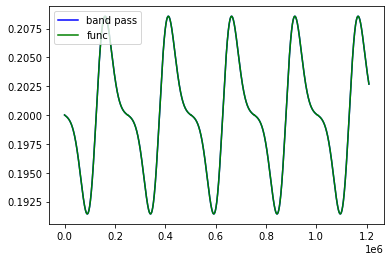

In [30]:
## Band Pass Filter - synthetic data - scaling function

h = ts[1]-ts[0]
L = ts[-1]-ts[0]
h_new = h*(2*np.pi/L)
ts1 = ts + h_new/200
pp = np.zeros_like(ts1)
for i, vi in enumerate(vs):
    hprime = h_new
    pp += vi*(np.sin(2*np.pi*np.pi*(ts1-ts[i])/h_new/L)-np.sin(2*np.pi*np.pi*(ts1-ts[i])/hprime/L))/(2*np.pi*np.pi*(ts1-ts[i])/h_new/L)            
    
plt.plot(ts1,vs - pp,'b',label="band pass")
plt.plot(ts1,vs,'g',label = "func")
plt.legend()

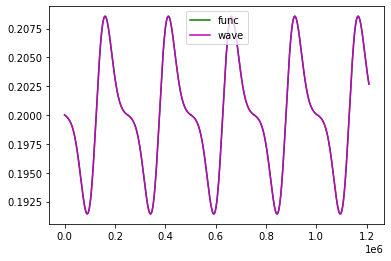

In [31]:
## Bandpass filter - scaling axis

ts1 = ts + h/200
L = ts[-1]-ts[0]
ts_new = ts/L*2*np.pi
h = ts_new[1]-ts_new[0]
ts1_new = ts_new + h/1000
p_wave = np.zeros_like(ts1_new)
for i, vi in enumerate(vs):
    hprime = h
    p_wave += vi*(np.sin(np.pi*(ts1_new-ts_new[i])/h)-np.sin(np.pi*(ts1_new-ts_new[i])/(hprime)))/(np.pi*(ts1_new-ts_new[i])/h)     


plt.plot(ts,vs,'g',label = "func")
plt.plot(ts1,vs-p_wave,'m',label = "wave")

plt.legend()

## Resetting axis

h = 300
ts=np.array(range(0,(2*7*24*60**2),h))

##### Gaussian Smoothing Kernel

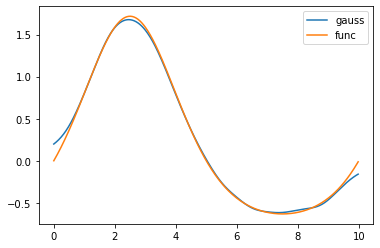

In [32]:
## Gaussian Kernel - function data

sigma = 1/(0.5*2*np.pi)
smoothed_cases = []
for i, vi in enumerate(func_vs):
    gkv = np.exp(-((xs - xs[i])**2/(2*sigma**2)))
    gkv /=gkv.sum()
    smoothed_cases.append(np.dot(func_vs,gkv))#(vs*gkv).sum())
    
plt.plot(xs,smoothed_cases,label="gauss")
plt.plot(xs,v(xs),label="func")
plt.legend()
    

Maybe the correspondance between sigma and the cut off frequency,$f_c$, is $f_c = \frac{1}{2\pi\sigma}$

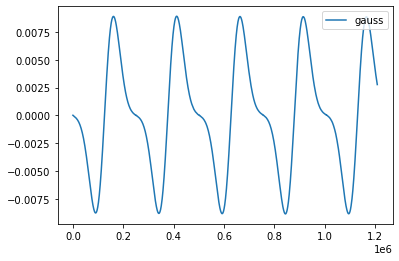

In [33]:
## Gaussian filter - synthetic data

# need to figure out scaling and sigma value

sigma = 20000
smoothed_cases = []
for i, vi in enumerate(vs):
    gkv = np.exp(-((ts - ts[i])**2/(2*sigma**2))) #1/(b*np.sqrt(2)*np.pi))*
 
    gkv /=gkv.sum()
    smoothed_cases.append(np.dot(vs,gkv))#(vs*gkv).sum())
    
plt.plot(ts,vs-smoothed_cases,label="gauss")
#plt.plot(ts,vs,label="data")
plt.legend()

### Applying filters and kernels to Eularian and Lagrangian Averaging

First we will apply the low and high pass filters to both the Eularian and Lagrangian data. After that we will focus on applying the filters/kernels to only the Lagrangian tracking data.

As the synthetic wave data is quite large, it takes a long time to apply the filters/kernels. So to shorten the time taken to run these tests, we will shrink our data. Instead of taking data at every timestep, we will only use every other timestep. Similarly we will only use every other x/y coordinate on the coordinate grid. This should make calculations 8 times faster.

In [34]:
fast_U = U[::2,::2,::2]
fast_ts = ts[::2]
fast_U_prtcl = U_prtcl[::2,::2,::2]
fast_h = 2*h
fast_Ntime = fast_U.shape[0]
fast_t_mid = np.int(fast_Ntime/2.)
fast_U_prtcl = U_prtcl[::2,::2,::2]
fast_L = fast_ts[-1]-fast_ts[0]
fast_x = x[::2]
fast_y = y[::2]

C:\Users\alexa\AppData\Local\Temp\ipykernel_3640\598840562.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fast_t_mid = np.int(fast_Ntime/2.)


##### Eularian and Lagrangian Frequency Cut Offs (LP & HP)

At the moment we are using a frequency cut off value of $\frac{f}{2\pi}$ as Shakespeare did. The next step in the investigation should be to check if the results improve when changing this.

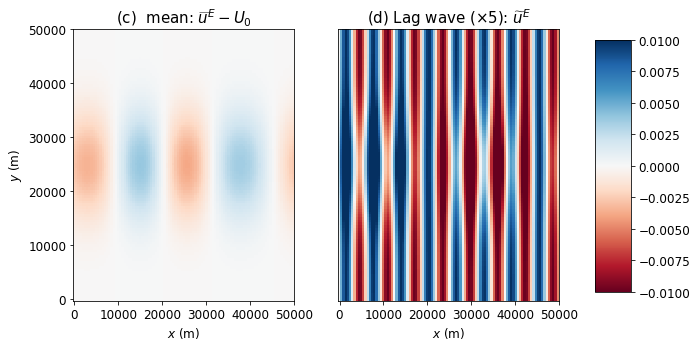

In [35]:
## Eularian frequency cut off 

freqss = scipy.fftpack.fftfreq(fast_ts.size, fast_h)
imax = np.shape(fast_U)[1]
jmax = np.shape(fast_U)[2]
U_wave = np.empty_like(fast_U_prtcl)

for i in range(imax):
    for j in range(jmax):
        Utseries = fast_U[:,i,j]
        Uhat = scipy.fftpack.rfft(Utseries)
        
        
        Uhat[abs(freqss)<=(f/2/np.pi)] = 0
        U_wave[:,i,j] = scipy.fftpack.irfft(Uhat)
        
fig1=plt.figure(figsize=(10,5))        
plt.subplot(1,2,1)
plt.pcolor(fast_x,fast_y,U_wave[fast_t_mid,:,:],vmin=-0.01,vmax=0.01,cmap='RdBu')
plt.title(r'(c)  mean: $\widebar{u}^E-U_0$',fontsize=15)
plt.tick_params(labelsize=12)
plt.ylabel(r'$y$ (m)',fontsize=12)
plt.xlabel(r'$x$ (m)',fontsize=12)


plt.subplot(1,2,2)
im=plt.pcolor(fast_x,fast_y,fast_U[fast_t_mid,:,:]-U_wave[fast_t_mid,:,:]-U0,vmin=-0.01,vmax=0.01,cmap='RdBu')
plt.title('u wave');
plt.title(r'(d) Lag wave ($\times$5): $\widetilde{u}^E$',fontsize=15);
plt.yticks([])
plt.tick_params(labelsize=12)
plt.xlabel(r'$x$ (m)',fontsize=12)

plt.subplots_adjust(right=0.8)
cbar_ax = fig1.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(im, cax=cbar_ax)
plt.tick_params(labelsize=12)

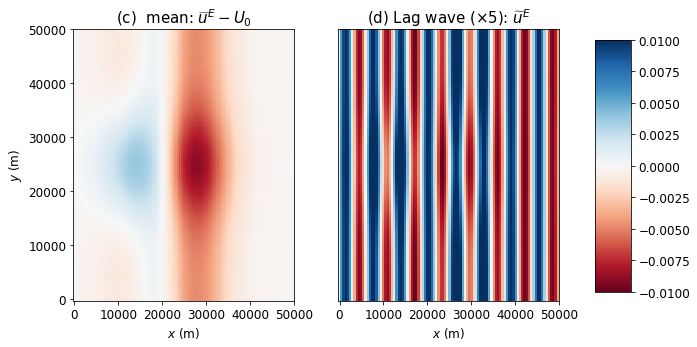

In [36]:
## Lagrangian frequency cut off 

freqss = scipy.fftpack.fftfreq(fast_ts.size, fast_h)
imax = np.shape(fast_U)[1]
jmax = np.shape(fast_U)[2]
U_wave = np.empty_like(fast_U_prtcl)

for i in range(imax):
    for j in range(jmax):
        Utseries = fast_U_prtcl[:,i,j]
        Uhat = scipy.fftpack.rfft(Utseries)
        
        
        Uhat[abs(freqss)<=(f/2/np.pi)] = 0
        U_wave[:,i,j] = scipy.fftpack.irfft(Uhat)
        
fig1=plt.figure(figsize=(10,5))        
plt.subplot(1,2,1)
plt.pcolor(fast_x,fast_y,fast_U_prtcl[fast_t_mid,:,:]-U_wave[fast_t_mid,:,:]-U0,vmin=-0.01,vmax=0.01,cmap='RdBu')
plt.title(r'(c)  mean: $\widebar{u}^E-U_0$',fontsize=15)
plt.tick_params(labelsize=12)
plt.ylabel(r'$y$ (m)',fontsize=12)
plt.xlabel(r'$x$ (m)',fontsize=12)


plt.subplot(1,2,2)
im=plt.pcolor(fast_x,fast_y,U_wave[fast_t_mid,:,:],vmin=-0.01,vmax=0.01,cmap='RdBu')
plt.title('u wave');
plt.title(r'(d) Lag wave ($\times$5): $\widetilde{u}^E$',fontsize=15);
plt.yticks([])
plt.tick_params(labelsize=12)
plt.xlabel(r'$x$ (m)',fontsize=12)

plt.subplots_adjust(right=0.8)
cbar_ax = fig1.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(im, cax=cbar_ax)
plt.tick_params(labelsize=12)

##### Non-Periodic Sinc Function on Lagrangian Tracking Data

In [37]:
U_wave = np.empty_like(fast_U_prtcl)


h_c = fast_h*(2*np.pi/fast_L)
fast_ts1 = fast_ts + h_c/2

for i in range(imax):
    for j in range(jmax):
        
        Utseries = fast_U_prtcl[:,i,j]

        p = np.zeros_like(fast_ts1)

        
        for k, vk in enumerate(Utseries):
            hprime = 50*h_c
            p += vk*np.sin(2*np.pi*np.pi*(fast_ts1-fast_ts[k])/hprime/fast_L)/(2*np.pi*np.pi*(fast_ts1-fast_ts[k])/h_c/fast_L)
        
        U_wave[:,i,j] = p

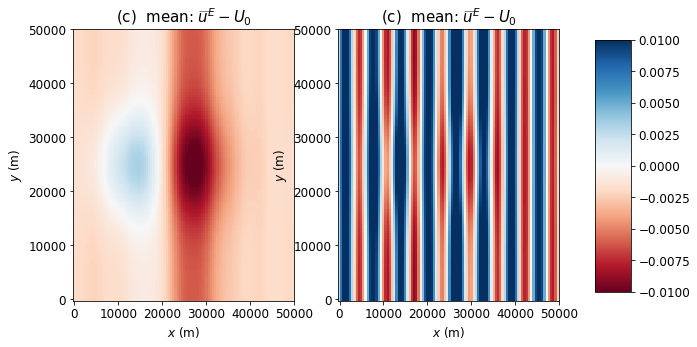

In [38]:
fig1=plt.figure(figsize=(10,5))        
plt.subplot(1,2,1)
plt.pcolor(fast_x,fast_y,U_wave[fast_t_mid,:,:]-U0,vmin=-0.01,vmax=0.01,cmap='RdBu')
plt.title(r'(c)  mean: $\widebar{u}^E-U_0$',fontsize=15)
plt.tick_params(labelsize=12)
plt.ylabel(r'$y$ (m)',fontsize=12)
plt.xlabel(r'$x$ (m)',fontsize=12)


plt.subplot(1,2,2)
plt.pcolor(fast_x,fast_y,fast_U_prtcl[fast_t_mid,:,:]-U_wave[fast_t_mid,:,:],vmin=-0.01,vmax=0.01,cmap='RdBu')
plt.title(r'(c)  mean: $\widebar{u}^E-U_0$',fontsize=15)
plt.tick_params(labelsize=12)
plt.ylabel(r'$y$ (m)',fontsize=12)
plt.xlabel(r'$x$ (m)',fontsize=12)


plt.subplots_adjust(right=0.8)
cbar_ax = fig1.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(im, cax=cbar_ax)
plt.tick_params(labelsize=12)

In [39]:
##### Periodic Sinc Function on Lagrangian Tracking Data

In [40]:
fast_ts1 = fast_ts + fast_h/2
p2 = np.zeros_like(fast_ts1)
L = fast_ts[-1]-fast_ts[0]
fast_ts1 = fast_ts1/fast_L*(2*np.pi)
fast_ts = fast_ts/fast_L*(2*np.pi)
fast_h = fast_ts[1]-fast_ts[0]

for i in range(imax):
    for j in range(jmax):
       
        Utseries = fast_U_prtcl[:,i,j]

        p2 = np.zeros_like(fast_ts1)
        
        for k, vk in enumerate(Utseries):
            hprime = 50*fast_h
            p2 += 1/(2*np.pi/fast_h)*vk*np.sin(np.pi*(fast_ts1-fast_ts[k])/hprime)/np.tan((fast_ts1-fast_ts[k])/2)    

        U_wave[:,i,j] = p2


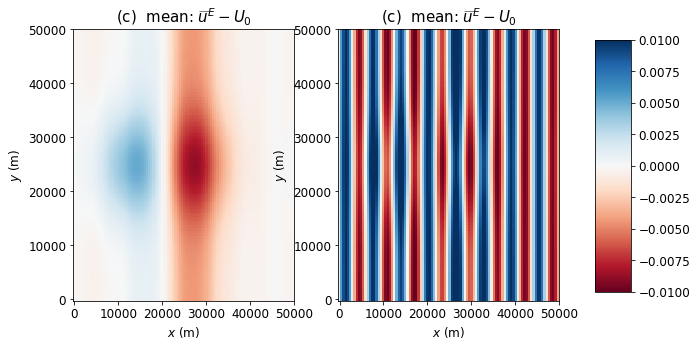

In [41]:
fig1=plt.figure(figsize=(10,5))        
plt.subplot(1,2,1)
plt.pcolor(fast_x,fast_y,U_wave[fast_t_mid,:,:]-U0,vmin=-0.01,vmax=0.01,cmap='RdBu')
plt.title(r'(c)  mean: $\widebar{u}^E-U_0$',fontsize=15)
plt.tick_params(labelsize=12)
plt.ylabel(r'$y$ (m)',fontsize=12)
plt.xlabel(r'$x$ (m)',fontsize=12)


plt.subplot(1,2,2)
plt.pcolor(fast_x,fast_y,fast_U_prtcl[fast_t_mid,:,:]-U_wave[fast_t_mid,:,:],vmin=-0.01,vmax=0.01,cmap='RdBu')
plt.title(r'(c)  mean: $\widebar{u}^E-U_0$',fontsize=15)
plt.tick_params(labelsize=12)
plt.ylabel(r'$y$ (m)',fontsize=12)
plt.xlabel(r'$x$ (m)',fontsize=12)


plt.subplots_adjust(right=0.8)
cbar_ax = fig1.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(im, cax=cbar_ax)
plt.tick_params(labelsize=12)

In [42]:
##### Band Pass Sinc Function on Lagrangian Tracking Data

In [43]:
U_wave = np.empty_like(fast_U_prtcl)


fast_h = fast_ts[1]-fast_ts[0]
fast_L = fast_ts[-1]-fast_ts[0]
h_c = fast_h*(2*np.pi/fast_L)
fast_ts1 = fast_ts + h_c/200

for i in range(imax):
    for j in range(jmax):
       
        Utseries = fast_U_prtcl[:,i,j]

        pp = np.zeros_like(fast_ts1)

       
        for k, vk in enumerate(Utseries):
            hprime = 50*h_c
            pp += vk*(np.sin(2*np.pi*np.pi*(fast_ts1-fast_ts[k])/h_c/fast_L)-np.sin(2*np.pi*np.pi*(fast_ts1-fast_ts[k])/hprime/fast_L))/(2*np.pi*np.pi*(fast_ts1-fast_ts[k])/h_c/fast_L)            
           
        U_wave[:,i,j] = pp

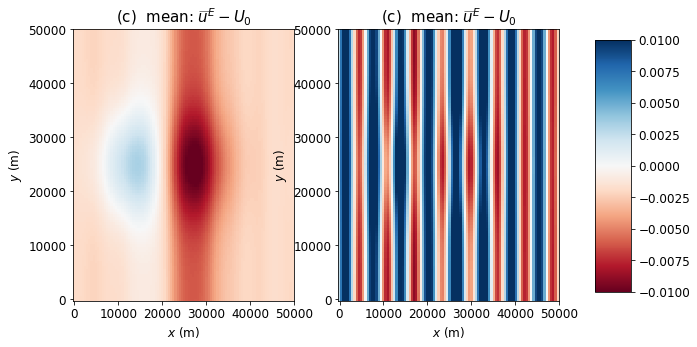

In [45]:
fig1=plt.figure(figsize=(10,5))        
plt.subplot(1,2,1)
plt.pcolor(fast_x,fast_y,fast_U_prtcl[fast_t_mid,:,:]-U_wave[fast_t_mid,:,:]-U0,vmin=-0.01,vmax=0.01,cmap='RdBu')
plt.title(r'(c)  mean: $\widebar{u}^E-U_0$',fontsize=15)
plt.tick_params(labelsize=12)
plt.ylabel(r'$y$ (m)',fontsize=12)
plt.xlabel(r'$x$ (m)',fontsize=12)


plt.subplot(1,2,2)
plt.pcolor(fast_x,fast_y,U_wave[fast_t_mid,:,:],vmin=-0.01,vmax=0.01,cmap='RdBu')
plt.title(r'(c)  mean: $\widebar{u}^E-U_0$',fontsize=15)
plt.tick_params(labelsize=12)
plt.ylabel(r'$y$ (m)',fontsize=12)
plt.xlabel(r'$x$ (m)',fontsize=12)


plt.subplots_adjust(right=0.8)
cbar_ax = fig1.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(im, cax=cbar_ax)
plt.tick_params(labelsize=12)